In [1]:
%load_ext autoreload
%autoreload 2

In [39]:
import argparse
import helpers
import os
from matplotlib import pyplot as plt

import numpy as np
import networkx as nx
from sklearn.metrics import log_loss
from decentralized_SGD_logistic import DecentralizedSGDLogistic
from sklearn.linear_model import SGDClassifier

## Higgs Boson Dataset

In [40]:
def run_logistic(A, y, param):
    m = DecentralizedSGDLogistic(**param)
    list_losses = m.fit(A, y, logging=True)
    print('Final score: {0:.4f}'.format(m.score(A, y)))
    return list_losses, np.arange(0.0, len(list_losses)) * m.compute_loss_every

## Load dataset

In [41]:
y, A = helpers.load_data()

## Compute the baseline with SGD classifier 

In [42]:
# Fit a SGD
clf = SGDClassifier(loss='log', penalty='l2', alpha =1/A.shape[0], tol=1e-4, n_jobs=1, random_state=2)
clf.fit(A, y)

accuracy = clf.score(A, y)
optimum_x = clf.predict_proba(A)[:, 1]

# Optimal loss, useful for plots
optimum_loss = (-(y.T.dot(np.log(optimum_x)) + (1 - y).T.dot(np.log(1 - optimum_x))) / A.shape[0])

print('Accuracy:', accuracy)
print('Final loss:', optimum_loss)

Accuracy: 0.7444
Final loss: 0.5063267378689544


## Computing with Decentralized SGD

### Cycle topologies to be used

In [5]:
def cycle_rw(p, n_states):
    """Return the transition matrix of a Markov chain corresponding
    to a cyclic random walk (no self-loops)
    :param p: the probability of going to one of the neighboring states
    :param n_states: number of states in the Markov chain"""
    q = 1-p

    W = np.zeros(shape=(n_states, n_states))
    np.fill_diagonal(W[1:], q, wrap=False)
    np.fill_diagonal(W[:, 1:], p, wrap=False)
    W[0, n_cores - 1] = q
    W[n_cores - 1, 0] = p
    return W

In [6]:
def cycle_lazy_rw(lazy_p, p, n_states):
    """Return the transition matrix of a Markov chain corresponding
    to a lazy cyclic random walk (self-loops are included)
    :param lazy_p: the probability of staying at the same state
    :param p: the probability of going to one of the neighboring states
    :param n_states: number of states in the Markov chain"""
    if lazy_p + p > 1:
        raise ValueError('Wrong proba')
    q = 1-p - lazy_p

    W = np.zeros(shape=(n_states, n_states))
    np.fill_diagonal(W, lazy_p, wrap=False)
    np.fill_diagonal(W[1:], q, wrap=False)
    np.fill_diagonal(W[:, 1:], p, wrap=False)
    W[0, n_cores - 1] = q
    W[n_cores - 1, 0] = p
    return W

### Comparison Unbalanced Ring with no self-loops VS Unbalanced Ring with self-loops

In [30]:
reg = 1 / A.shape[0]
n_features = A.shape[1]

params_cyle_rw = dict(num_epoch=5, lr_type='bottou',
                           initial_lr=0.1, regularizer=reg,
                           quantization_method='full', n_machines=255,
                           communication_method='plain',topology=cycle_rw(0.7, 255),
                           data_distribution_random_seed=2, random_seed=2,
                           data_distribution_strategy='naive', tol=1e-6, compute_loss_every=5)

list_losses_rw, list_iterations_rw = run_logistic(A, y, params_cyle_rw)

params_cyle_lazy_rw = dict(num_epoch=5, lr_type='bottou',
                           initial_lr=0.1, regularizer=reg,
                           quantization_method='full', n_machines=255,
                           communication_method='plain',topology=cycle_lazy_rw(0.3, 0.6, 255),
                           data_distribution_random_seed=2, random_seed=2,
                           data_distribution_strategy='naive', tol=1e-6, compute_loss_every=5)

list_losses_lazy_rw, list_iterations_lazy_rw = run_logistic(A, y, params_cyle_lazy_rw)

Epoch      Iteration      Time      Loss      Accuracy      
[1/5]      [980/980]      24s       5.9997    0.6834        
[2/5]      [980/980]      49s       7.9555    0.6837        
[3/5]      [980/980]      76s       8.6957    0.6841        
[4/5]      [980/980]      103s      9.0295    0.6851        
[5/5]      [980/980]      129s      9.1662    0.6866        
Final score: 0.6866
Epoch      Iteration      Time      Loss      Accuracy      
[1/5]      [980/980]      28s       0.5648    0.7250        
[2/5]      [980/980]      57s       0.5647    0.7273        
[3/5]      [980/980]      88s       0.5638    0.7277        
[4/5]      [980/980]      117s      0.5636    0.7262        
[5/5]      [980/980]      146s      0.5633    0.7266        
Final score: 0.7266


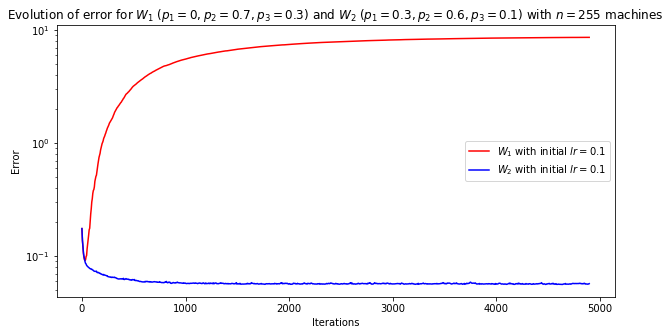

In [31]:
plt.figure(figsize=(10, 5))

plt.plot(list_iterations_rw, list_losses_rw - optimum_loss, 'r', label='$W_1$ with initial $lr=0.1$')
plt.plot(list_iterations_rw, list_losses_lazy_rw - optimum_loss, 'b', label='$W_2$ with initial $lr=0.1$')

plt.yscale('log')
plt.title('Evolution of error for $W_1 \; (p_1=0, p_2=0.7, p_3=0.3)$ and $W_2 \; (p_1=0.3, p_2=0.6, p_3=0.1)$ with $n=255$ machines')
plt.xlabel('Iterations')
plt.ylabel('Error')
plt.legend(loc="best")

plt.show()

### Comparison Ring with no self-loops VS Ring close to no self-loops

In [32]:
reg = 1 / A.shape[0]
n_features = A.shape[1]

params_cyle_rw_new = dict(num_epoch=5, lr_type='bottou',
                           initial_lr=0.1, regularizer=reg,
                           quantization_method='full', n_machines=255,
                           communication_method='plain',topology=cycle_rw(0.5, 255),
                           data_distribution_random_seed=2, random_seed=2,
                           data_distribution_strategy='naive', tol=1e-10, compute_loss_every=5)

list_losses_rw_new, list_iterations_rw_new = run_logistic(A, y, params_cyle_rw_new)

params_cyle_lazy_rw_new = dict(num_epoch=5, lr_type='bottou',
                           initial_lr=0.1, regularizer=reg,
                           quantization_method='full', n_machines=255,
                           communication_method='plain',topology=cycle_lazy_rw(0.01, 0.5, 255),
                           data_distribution_random_seed=2, random_seed=2,
                           data_distribution_strategy='naive', tol=1e-10, compute_loss_every=5)

list_losses_lazy_rw_new, list_iterations_lazy_rw_new = run_logistic(A, y, params_cyle_lazy_rw_new)

params_cyle_rw_new2 = dict(num_epoch=5, lr_type='bottou',
                           initial_lr=0.01, regularizer=reg,
                           quantization_method='full', n_machines=255,
                           communication_method='plain',topology=cycle_rw(0.5, 255),
                           data_distribution_random_seed=2, random_seed=2,
                           data_distribution_strategy='naive', tol=1e-10, compute_loss_every=5)

list_losses_rw_new2, list_iterations_rw_new2 = run_logistic(A, y, params_cyle_rw_new2)

params_cyle_lazy_rw_new2 = dict(num_epoch=5, lr_type='bottou',
                           initial_lr=0.01, regularizer=reg,
                           quantization_method='full', n_machines=255,
                           communication_method='plain',topology=cycle_lazy_rw(0.01, 0.5, 255),
                           data_distribution_random_seed=2, random_seed=2,
                           data_distribution_strategy='naive', tol=1e-10, compute_loss_every=5)

list_losses_lazy_rw_new2, list_iterations_lazy_rw_new2 = run_logistic(A, y, params_cyle_lazy_rw_new2)

Epoch      Iteration      Time      Loss      Accuracy      
[1/5]      [980/980]      27s       6.0689    0.6832        
[2/5]      [980/980]      54s       7.8937    0.6838        
[3/5]      [980/980]      82s       8.5678    0.6850        
[4/5]      [980/980]      113s      8.8684    0.6863        
[5/5]      [980/980]      142s      8.9647    0.6888        
Final score: 0.6888
Epoch      Iteration      Time      Loss      Accuracy      
[1/5]      [980/980]      30s       1.0588    0.7184        
[2/5]      [980/980]      61s       1.0467    0.7260        
[3/5]      [980/980]      95s       1.0121    0.7295        
[4/5]      [980/980]      135s      1.0171    0.7288        
[5/5]      [980/980]      172s      1.0058    0.7314        
Final score: 0.7314
Epoch      Iteration      Time      Loss      Accuracy      
[1/5]      [980/980]      33s       0.8291    0.6893        
[2/5]      [980/980]      66s       1.6940    0.6840        
[3/5]      [980/980]      98s       2.5781   

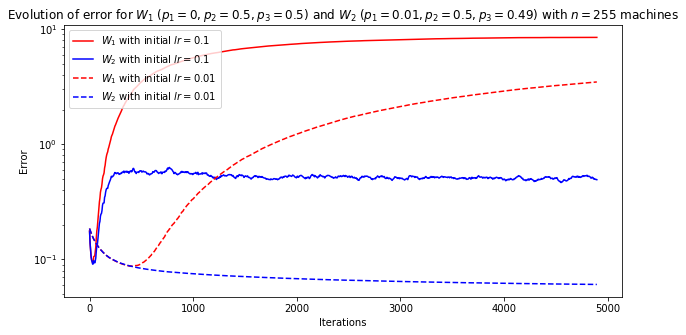

In [33]:
plt.figure(figsize=(10, 5))

plt.plot(list_iterations_lazy_rw_new2, list_losses_rw_new-optimum_loss, 'r', label='$W_1$ with initial $lr=0.1$')
plt.plot(list_iterations_lazy_rw_new2, list_losses_lazy_rw_new-optimum_loss, 'b', label='$W_2$ with initial $lr=0.1$')
plt.plot(list_iterations_lazy_rw_new2, list_losses_rw_new2-optimum_loss, 'r--', label='$W_1$ with initial $lr=0.01$')
plt.plot(list_iterations_lazy_rw_new2, list_losses_lazy_rw_new2-optimum_loss, 'b--', label='$W_2$ with initial $lr=0.01$')

plt.yscale('log')
plt.title('Evolution of error for $W_1 \; (p_1=0, p_2=0.5, p_3=0.5)$ and $W_2 \; (p_1=0.01, p_2=0.5, p_3=0.49)$ with $n=255$ machines')
plt.xlabel('Iterations')
plt.ylabel('Error')
plt.legend(loc="best")

plt.show()